LSTM Model - 1-HOUR Window Analysis
Sequence length: 12 timesteps (1 hour of history)
Prediction: One-step ahead (next 5 minutes)

Total samples: 16089
Date range  : 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00
Training samples: 15801
Testing samples : 288
Analyzing 1-hour window (12 samples)

Creating sequences for LSTM...
Train sequences shape: (15789, 12, 4)
Test sequences shape: (276, 12, 4)
Train targets shape: (15789,)
Test targets shape: (276,)

Scaled train sequences shape: (15789, 12, 4)
Scaled test sequences shape: (276, 12, 4)

Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM model...
Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 130s 329ms/step - loss: 201.7936 - mae: 11.4832 - val_loss: 4.4350 - val_mae: 1.6602
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 129s 328ms/step - loss: 3.2227 - mae: 1.2594 - val_loss: 0.6875 - val_mae: 0.5784
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 123s 313ms/step - loss: 0.5877 - mae: 0.5207 - val_loss: 0.4300 - val_mae: 0.4483
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 127s 323ms/step - loss: 0.3937 - mae: 0.4269 - val_loss: 0.3388 - val_mae: 0.3767
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 136s 345ms/step - loss: 0.3854 - mae: 0.4155 - val_loss: 0.3142 - val_mae: 0.3457
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 134s 339ms/step - loss: 0.3502 - mae: 0.3990 - val_loss: 0.2953 - val_mae: 0.3396
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 134s 340ms/step - loss: 0.3372 - mae: 0.3843 - val_loss: 0.3113 - val_mae: 0.3726
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 130s 329ms/step - loss: 0.3374 - mae: 0.3881 - val_loss: 0.2918 - val_mae:

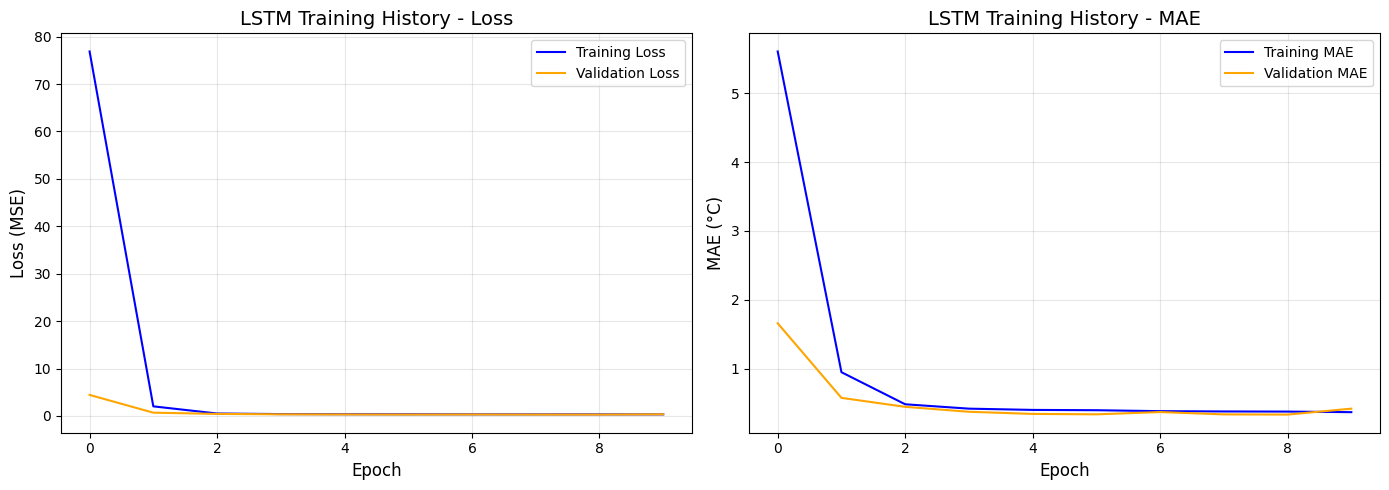

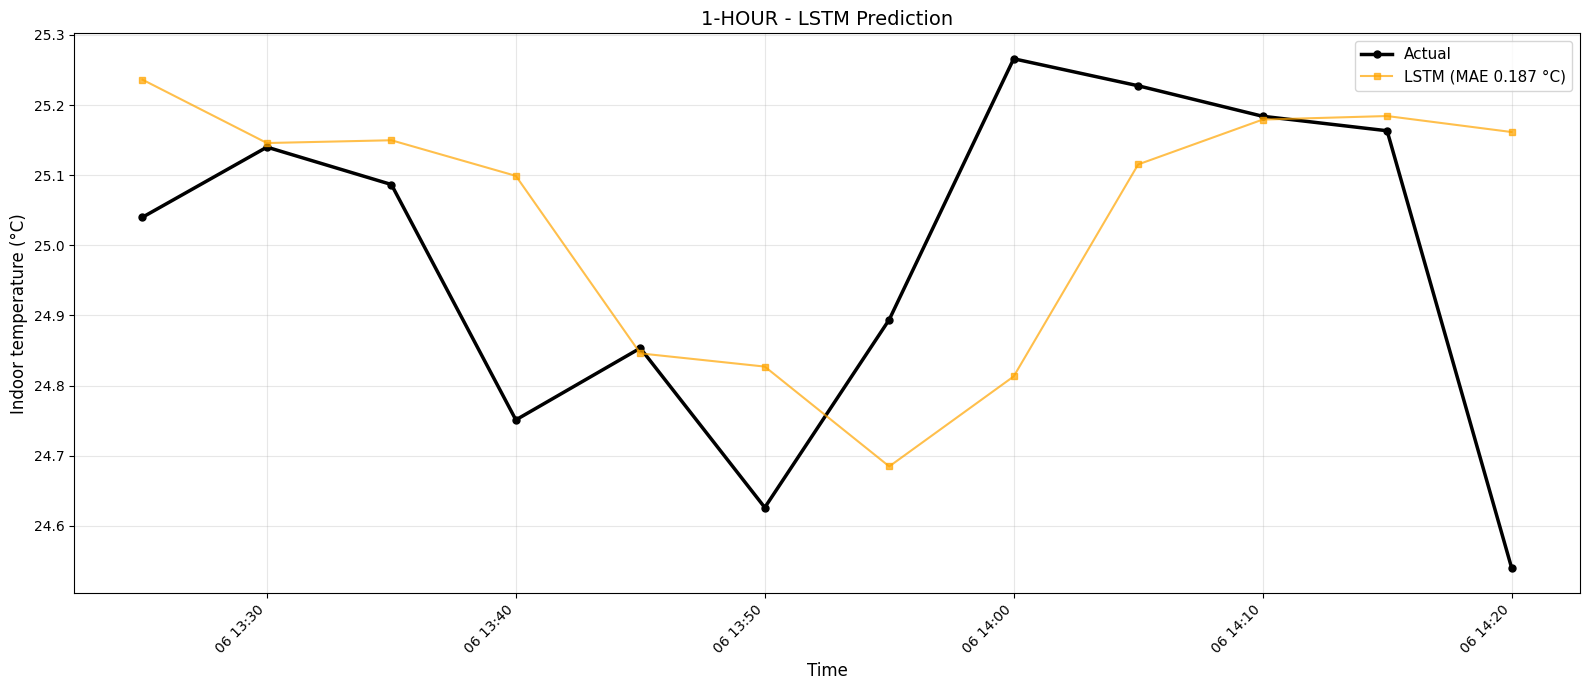

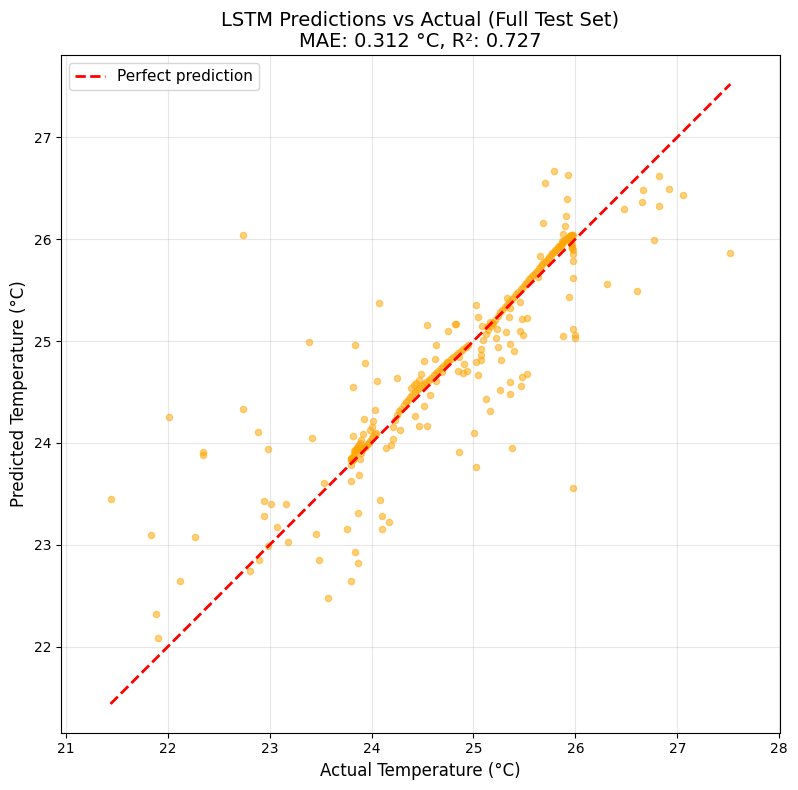


ANALYSIS COMPLETE FOR 1-HOUR WINDOW

LSTM Results Summary:
  Sequence length : 12 timesteps
  Full test MAE   : 0.3125 °C
  Window MAE      : 0.1869 °C
  Window RMSE     : 0.2665 °C
  Window R²       : -0.3042

Compare these results with FNN, ODE, PINN, and XGBoost models!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# BASIC SETTINGS
# -----------------------------
plt.rcParams["figure.figsize"] = (12, 4)

DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0          # 5-min data
TEST_DAYS = 1                    # last 1 day as test
SAMPLES_PER_DAY = 288            # 24*60 / 5
TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

# WINDOW SPECIFICATION - 1 HOUR
WINDOW_NAME = "1-hour"
WINDOW_SAMPLES = 12  # 1 hour = 12 samples (5-min intervals)

# LSTM CONFIGURATION
SEQUENCE_LENGTH = 12  # Use last 12 timesteps (1 hour) to predict next step

print("="*80)
print(f"LSTM Model - {WINDOW_NAME.upper()} Window Analysis")
print("="*80)
print(f"Sequence length: {SEQUENCE_LENGTH} timesteps (1 hour of history)")
print(f"Prediction: One-step ahead (next 5 minutes)")

try:
    full_data = pd.read_csv(DATA_FILE)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

    # Keep only rows where all key variables are present
    full_data = full_data.dropna(
        subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    ).reset_index(drop=True)

    if len(full_data) < TEST_SIZE:
        raise ValueError(f"Dataset too small! Need at least {TEST_SIZE} rows, got {len(full_data)}")

    print(f"\nTotal samples: {len(full_data)}")
    print(f"Date range  : {full_data['time'].min()} to {full_data['time'].max()}")

except FileNotFoundError:
    print(f"ERROR: Data file '{DATA_FILE}' not found in current directory.")
    raise
except Exception as e:
    print("ERROR while loading data:", e)
    raise

# Split into train and test (SAME AS OTHER MODELS)
train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples : {len(test_data)}")
print(f"Analyzing {WINDOW_NAME} window ({WINDOW_SAMPLES} samples)\n")

# =========================================================
# PREPARE SEQUENCES FOR LSTM
# =========================================================

def create_sequences(data, seq_length):
    """
    Create sequences for LSTM
    Input: last seq_length timesteps of [supply_air, outdoor_temp, satellite_value, indoor_temp]
    Output: indoor_temp at next timestep (one-step ahead prediction)
    """
    features = ["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    
    X_sequences = []
    y_targets = []
    
    for i in range(seq_length, len(data)):
        # Input: last seq_length rows
        X_sequences.append(data[features].iloc[i-seq_length:i].values)
        # Target: indoor_temp at current timestep
        y_targets.append(data["indoor_temp"].iloc[i])
    
    return np.array(X_sequences, dtype=np.float32), np.array(y_targets, dtype=np.float32)

print("Creating sequences for LSTM...")
X_train_seq, y_train = create_sequences(train_data, SEQUENCE_LENGTH)
X_test_seq, y_test = create_sequences(test_data, SEQUENCE_LENGTH)

print(f"Train sequences shape: {X_train_seq.shape}")  # (N, seq_len, 4)
print(f"Test sequences shape: {X_test_seq.shape}")
print(f"Train targets shape: {y_train.shape}")
print(f"Test targets shape: {y_test.shape}")

# =========================================================
# SCALE DATA
# =========================================================

# Scale features
scaler_X = RobustScaler()
X_train_flat = X_train_seq.reshape(-1, X_train_seq.shape[-1])
X_test_flat = X_test_seq.reshape(-1, X_test_seq.shape[-1])

X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_test_scaled_flat = scaler_X.transform(X_test_flat)

X_train_scaled = X_train_scaled_flat.reshape(X_train_seq.shape)
X_test_scaled = X_test_scaled_flat.reshape(X_test_seq.shape)

# Don't scale targets - keep in original units for fair comparison
# (Other models also predict in original units)

print(f"\nScaled train sequences shape: {X_train_scaled.shape}")
print(f"Scaled test sequences shape: {X_test_scaled.shape}")

# =========================================================
# BUILD AND TRAIN LSTM MODEL
# =========================================================

print("\nBuilding LSTM model...")

model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, 4)),  # (sequence_length, num_features)
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output: single value (indoor_temp)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(model.summary())

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining LSTM model...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# =========================================================
# MAKE PREDICTIONS
# =========================================================

print("\nMaking predictions...")
y_pred_train = model.predict(X_train_scaled, verbose=0).flatten()
y_pred_test = model.predict(X_test_scaled, verbose=0).flatten()

# =========================================================
# FULL TEST SET METRICS
# =========================================================

lstm_mae_full = mean_absolute_error(y_test, y_pred_test)
lstm_rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_test))
lstm_r2_full = r2_score(y_test, y_pred_test)
lstm_train_mae = mean_absolute_error(y_train, y_pred_train)

print("\nLSTM Performance on Full Test Set:")
print(f"  Train MAE: {lstm_train_mae:.4f} °C")
print(f"  Test MAE : {lstm_mae_full:.4f} °C")
print(f"  Test RMSE: {lstm_rmse_full:.4f} °C")
print(f"  Test R²  : {lstm_r2_full:.4f}")

# =========================================================
# WINDOW-SPECIFIC METRICS
# =========================================================

print("\n" + "="*80)
print(f"METRICS FOR {WINDOW_NAME.upper()} WINDOW ({WINDOW_SAMPLES} samples)")
print("="*80)

# Calculate metrics for the specific window
window_size = min(WINDOW_SAMPLES, len(y_test))

lstm_mae_w = mean_absolute_error(y_test[:window_size], y_pred_test[:window_size])
lstm_rmse_w = np.sqrt(mean_squared_error(y_test[:window_size], y_pred_test[:window_size]))
lstm_r2_w = r2_score(y_test[:window_size], y_pred_test[:window_size])

print(f"\n{'Model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'LSTM':<18} {lstm_mae_w:<12.4f} {lstm_rmse_w:<12.4f} {lstm_r2_w:<8.4f}")

# =========================================================
# TRAINING HISTORY VISUALIZATION
# =========================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('LSTM Training History - Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', color='blue')
ax2.plot(history.history['val_mae'], label='Validation MAE', color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE (°C)', fontsize=12)
ax2.set_title('LSTM Training History - MAE', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =========================================================
# PREDICTION VISUALIZATION
# =========================================================

# Prepare time axis for test data (accounting for sequence length)
time_test = test_data["time"].iloc[SEQUENCE_LENGTH:SEQUENCE_LENGTH+window_size].values
y_true_w = y_test[:window_size]
lstm_pred_w = y_pred_test[:window_size]

plt.figure(figsize=(16, 7))
plt.plot(time_test, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_test, lstm_pred_w, "s-", label=f"LSTM (MAE {lstm_mae_w:.3f} °C)", 
         color="orange", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()} - LSTM Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# =========================================================
# SCATTER PLOT: PREDICTED VS ACTUAL
# =========================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5, s=20, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.title(f'LSTM Predictions vs Actual (Full Test Set)\nMAE: {lstm_mae_full:.3f} °C, R²: {lstm_r2_full:.3f}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# =========================================================
# COMPARISON SUMMARY
# =========================================================

print("\n" + "="*80)
print(f"ANALYSIS COMPLETE FOR {WINDOW_NAME.upper()} WINDOW")
print("="*80)
print(f"\nLSTM Results Summary:")
print(f"  Sequence length : {SEQUENCE_LENGTH} timesteps")
print(f"  Full test MAE   : {lstm_mae_full:.4f} °C")
print(f"  Window MAE      : {lstm_mae_w:.4f} °C")
print(f"  Window RMSE     : {lstm_rmse_w:.4f} °C")
print(f"  Window R²       : {lstm_r2_w:.4f}")
print("\nCompare these results with FNN, ODE, PINN, and XGBoost models!")
print("="*80)

LSTM Model - 6-HOUR Window Analysis
Sequence length: 12 timesteps (1 hour of history)
Prediction: One-step ahead (next 5 minutes)

Total samples: 16089
Date range  : 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00
Training samples: 15801
Testing samples : 288
Analyzing 6-hour window (72 samples)

Creating sequences for LSTM...
Train sequences shape: (15789, 12, 4)
Test sequences shape: (276, 12, 4)
Train targets shape: (15789,)
Test targets shape: (276,)

Scaled train sequences shape: (15789, 12, 4)
Scaled test sequences shape: (276, 12, 4)

Building LSTM model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 12, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM model...
Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 133s 336ms/step - loss: 199.7856 - mae: 11.6173 - val_loss: 4.3698 - val_mae: 1.6336
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 122s 310ms/step - loss: 5.2053 - mae: 1.6566 - val_loss: 1.7275 - val_mae: 0.9671
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 134s 339ms/step - loss: 1.3558 - mae: 0.7795 - val_loss: 0.6618 - val_mae: 0.5628
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 131s 330ms/step - loss: 0.6298 - mae: 0.5383 - val_loss: 0.4303 - val_mae: 0.4454
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 126s 319ms/step - loss: 0.4594 - mae: 0.4650 - val_loss: 0.3310 - val_mae: 0.3626
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 123s 312ms/step - loss: 0.3638 - mae: 0.4040 - val_loss: 0.3152 - val_mae: 0.3610
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - loss: 0.3624 - mae: 0.3985 - val_loss: 0.3223 - val_mae: 0.3871
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.3449 - mae: 0.3852 - val_loss: 0.2826 - val_mae: 0.3

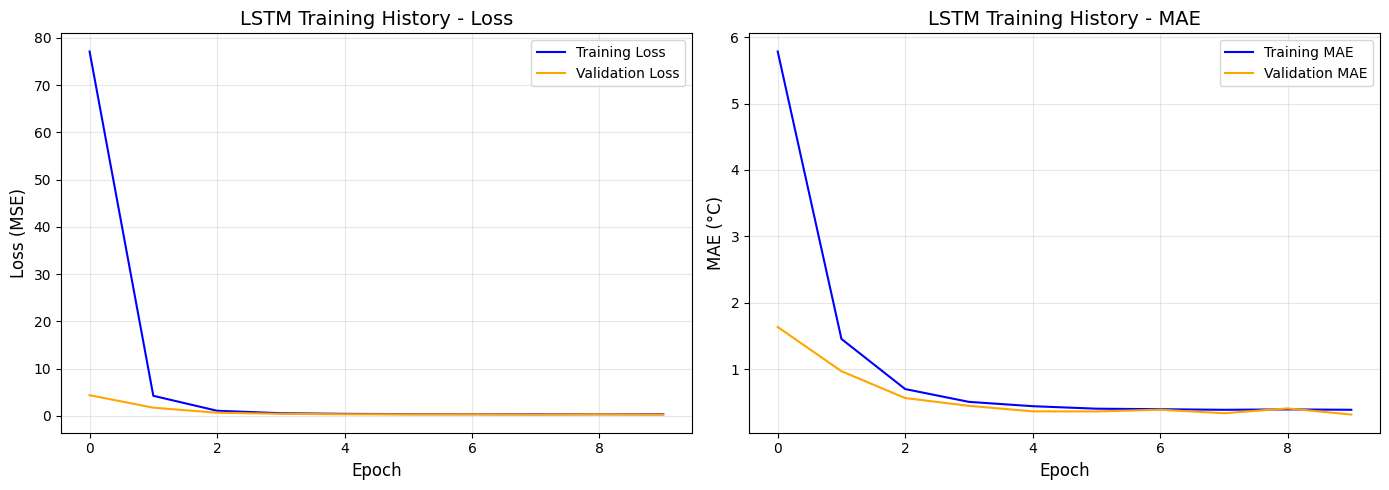

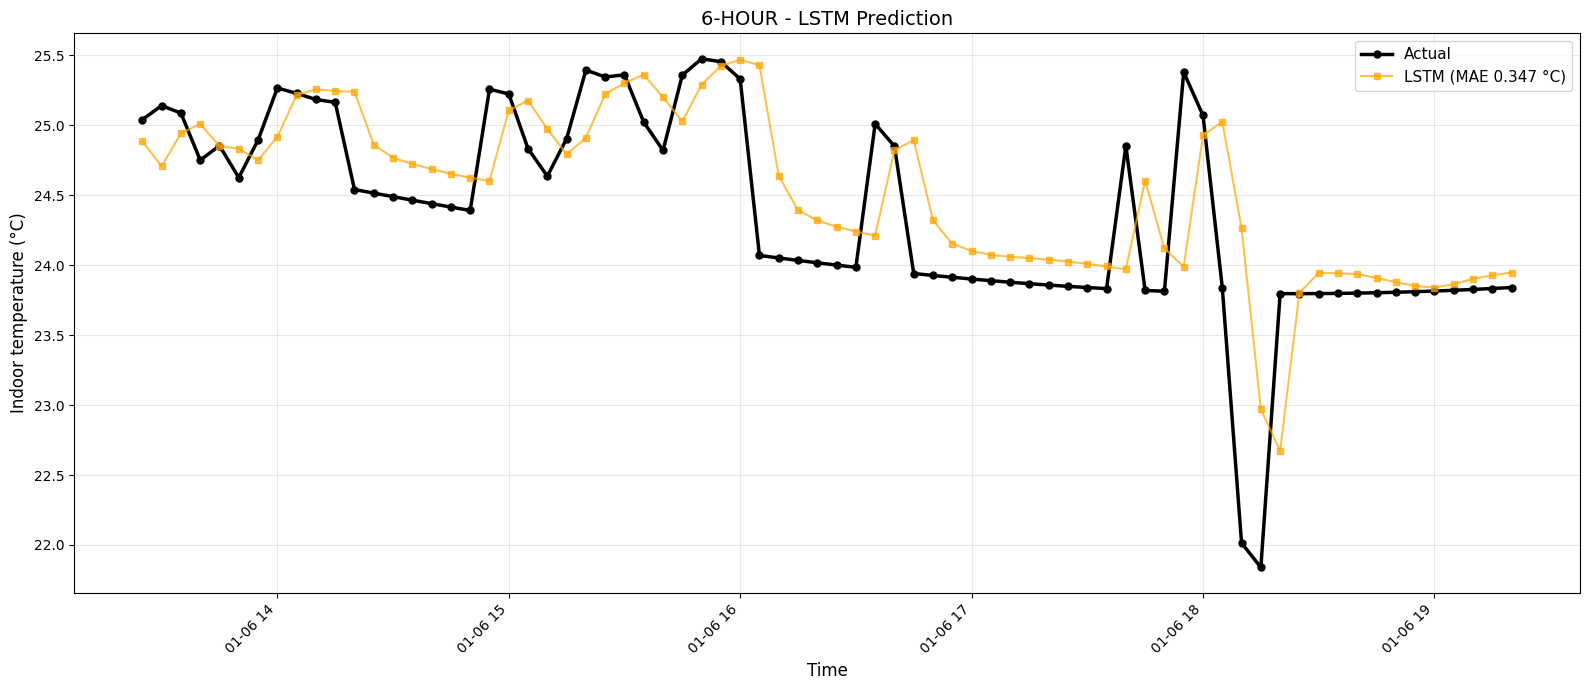

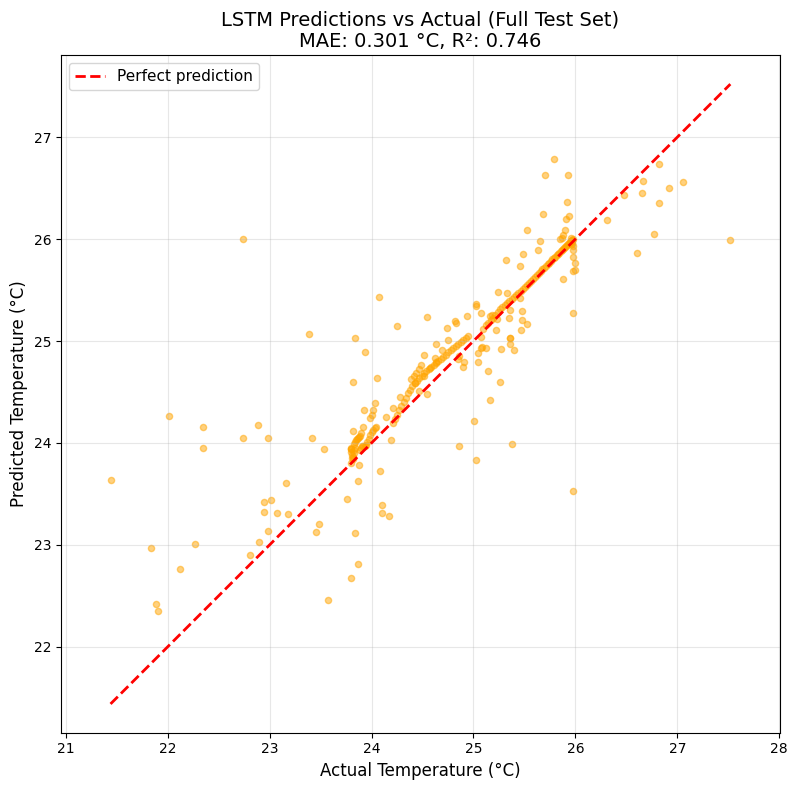


ANALYSIS COMPLETE FOR 6-HOUR WINDOW

LSTM Results Summary:
  Sequence length : 12 timesteps
  Full test MAE   : 0.3014 °C
  Window MAE      : 0.3469 °C
  Window RMSE     : 0.5260 °C
  Window R²       : 0.4730

Compare these results with FNN, ODE, PINN, and XGBoost models!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# BASIC SETTINGS
# -----------------------------
plt.rcParams["figure.figsize"] = (12, 4)

DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0          # 5-min data
TEST_DAYS = 1                    # last 1 day as test
SAMPLES_PER_DAY = 288            # 24*60 / 5
TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

# WINDOW SPECIFICATION - 1 HOUR
WINDOW_NAME = "6-hour"
WINDOW_SAMPLES = 72  # 1 hour = 12 samples (5-min intervals)

# LSTM CONFIGURATION
SEQUENCE_LENGTH = 12  # Use last 12 timesteps (1 hour) to predict next step

print("="*80)
print(f"LSTM Model - {WINDOW_NAME.upper()} Window Analysis")
print("="*80)
print(f"Sequence length: {SEQUENCE_LENGTH} timesteps (1 hour of history)")
print(f"Prediction: One-step ahead (next 5 minutes)")

try:
    full_data = pd.read_csv(DATA_FILE)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

    # Keep only rows where all key variables are present
    full_data = full_data.dropna(
        subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    ).reset_index(drop=True)

    if len(full_data) < TEST_SIZE:
        raise ValueError(f"Dataset too small! Need at least {TEST_SIZE} rows, got {len(full_data)}")

    print(f"\nTotal samples: {len(full_data)}")
    print(f"Date range  : {full_data['time'].min()} to {full_data['time'].max()}")

except FileNotFoundError:
    print(f"ERROR: Data file '{DATA_FILE}' not found in current directory.")
    raise
except Exception as e:
    print("ERROR while loading data:", e)
    raise

# Split into train and test (SAME AS OTHER MODELS)
train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples : {len(test_data)}")
print(f"Analyzing {WINDOW_NAME} window ({WINDOW_SAMPLES} samples)\n")

# =========================================================
# PREPARE SEQUENCES FOR LSTM
# =========================================================

def create_sequences(data, seq_length):
    """
    Create sequences for LSTM
    Input: last seq_length timesteps of [supply_air, outdoor_temp, satellite_value, indoor_temp]
    Output: indoor_temp at next timestep (one-step ahead prediction)
    """
    features = ["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    
    X_sequences = []
    y_targets = []
    
    for i in range(seq_length, len(data)):
        # Input: last seq_length rows
        X_sequences.append(data[features].iloc[i-seq_length:i].values)
        # Target: indoor_temp at current timestep
        y_targets.append(data["indoor_temp"].iloc[i])
    
    return np.array(X_sequences, dtype=np.float32), np.array(y_targets, dtype=np.float32)

print("Creating sequences for LSTM...")
X_train_seq, y_train = create_sequences(train_data, SEQUENCE_LENGTH)
X_test_seq, y_test = create_sequences(test_data, SEQUENCE_LENGTH)

print(f"Train sequences shape: {X_train_seq.shape}")  # (N, seq_len, 4)
print(f"Test sequences shape: {X_test_seq.shape}")
print(f"Train targets shape: {y_train.shape}")
print(f"Test targets shape: {y_test.shape}")

# =========================================================
# SCALE DATA
# =========================================================

# Scale features
scaler_X = RobustScaler()
X_train_flat = X_train_seq.reshape(-1, X_train_seq.shape[-1])
X_test_flat = X_test_seq.reshape(-1, X_test_seq.shape[-1])

X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_test_scaled_flat = scaler_X.transform(X_test_flat)

X_train_scaled = X_train_scaled_flat.reshape(X_train_seq.shape)
X_test_scaled = X_test_scaled_flat.reshape(X_test_seq.shape)

# Don't scale targets - keep in original units for fair comparison
# (Other models also predict in original units)

print(f"\nScaled train sequences shape: {X_train_scaled.shape}")
print(f"Scaled test sequences shape: {X_test_scaled.shape}")

# =========================================================
# BUILD AND TRAIN LSTM MODEL
# =========================================================

print("\nBuilding LSTM model...")

model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, 4)),  # (sequence_length, num_features)
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output: single value (indoor_temp)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(model.summary())

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining LSTM model...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# =========================================================
# MAKE PREDICTIONS
# =========================================================

print("\nMaking predictions...")
y_pred_train = model.predict(X_train_scaled, verbose=0).flatten()
y_pred_test = model.predict(X_test_scaled, verbose=0).flatten()

# =========================================================
# FULL TEST SET METRICS
# =========================================================

lstm_mae_full = mean_absolute_error(y_test, y_pred_test)
lstm_rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_test))
lstm_r2_full = r2_score(y_test, y_pred_test)
lstm_train_mae = mean_absolute_error(y_train, y_pred_train)

print("\nLSTM Performance on Full Test Set:")
print(f"  Train MAE: {lstm_train_mae:.4f} °C")
print(f"  Test MAE : {lstm_mae_full:.4f} °C")
print(f"  Test RMSE: {lstm_rmse_full:.4f} °C")
print(f"  Test R²  : {lstm_r2_full:.4f}")

# =========================================================
# WINDOW-SPECIFIC METRICS
# =========================================================

print("\n" + "="*80)
print(f"METRICS FOR {WINDOW_NAME.upper()} WINDOW ({WINDOW_SAMPLES} samples)")
print("="*80)

# Calculate metrics for the specific window
window_size = min(WINDOW_SAMPLES, len(y_test))

lstm_mae_w = mean_absolute_error(y_test[:window_size], y_pred_test[:window_size])
lstm_rmse_w = np.sqrt(mean_squared_error(y_test[:window_size], y_pred_test[:window_size]))
lstm_r2_w = r2_score(y_test[:window_size], y_pred_test[:window_size])

print(f"\n{'Model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'LSTM':<18} {lstm_mae_w:<12.4f} {lstm_rmse_w:<12.4f} {lstm_r2_w:<8.4f}")

# =========================================================
# TRAINING HISTORY VISUALIZATION
# =========================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('LSTM Training History - Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', color='blue')
ax2.plot(history.history['val_mae'], label='Validation MAE', color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE (°C)', fontsize=12)
ax2.set_title('LSTM Training History - MAE', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =========================================================
# PREDICTION VISUALIZATION
# =========================================================

# Prepare time axis for test data (accounting for sequence length)
time_test = test_data["time"].iloc[SEQUENCE_LENGTH:SEQUENCE_LENGTH+window_size].values
y_true_w = y_test[:window_size]
lstm_pred_w = y_pred_test[:window_size]

plt.figure(figsize=(16, 7))
plt.plot(time_test, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_test, lstm_pred_w, "s-", label=f"LSTM (MAE {lstm_mae_w:.3f} °C)", 
         color="orange", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()} - LSTM Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# =========================================================
# SCATTER PLOT: PREDICTED VS ACTUAL
# =========================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5, s=20, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.title(f'LSTM Predictions vs Actual (Full Test Set)\nMAE: {lstm_mae_full:.3f} °C, R²: {lstm_r2_full:.3f}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# =========================================================
# COMPARISON SUMMARY
# =========================================================

print("\n" + "="*80)
print(f"ANALYSIS COMPLETE FOR {WINDOW_NAME.upper()} WINDOW")
print("="*80)
print(f"\nLSTM Results Summary:")
print(f"  Sequence length : {SEQUENCE_LENGTH} timesteps")
print(f"  Full test MAE   : {lstm_mae_full:.4f} °C")
print(f"  Window MAE      : {lstm_mae_w:.4f} °C")
print(f"  Window RMSE     : {lstm_rmse_w:.4f} °C")
print(f"  Window R²       : {lstm_r2_w:.4f}")
print("\nCompare these results with FNN, ODE, PINN, and XGBoost models!")
print("="*80)

LSTM Model - 12-HOUR Window Analysis
Sequence length: 12 timesteps (1 hour of history)
Prediction: One-step ahead (next 5 minutes)

Total samples: 16089
Date range  : 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00
Training samples: 15801
Testing samples : 288
Analyzing 12-hour window (144 samples)

Creating sequences for LSTM...
Train sequences shape: (15789, 12, 4)
Test sequences shape: (276, 12, 4)
Train targets shape: (15789,)
Test targets shape: (276,)

Scaled train sequences shape: (15789, 12, 4)
Scaled test sequences shape: (276, 12, 4)

Building LSTM model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 12, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM model...
Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 235.9345 - mae: 13.5389 - val_loss: 4.4627 - val_mae: 1.6533
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 5.5355 - mae: 1.7118 - val_loss: 4.2518 - val_mae: 1.6081
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 4.6614 - mae: 1.5522 - val_loss: 2.0736 - val_mae: 1.0675
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 1.3833 - mae: 0.8165 - val_loss: 0.8770 - val_mae: 0.6638
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.5998 - mae: 0.5293 - val_loss: 0.4750 - val_mae: 0.4683
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.4384 - mae: 0.4524 - val_loss: 0.3716 - val_mae: 0.4155
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.3763 - mae: 0.4102 - val_loss: 0.3262 - val_mae: 0.3834
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.3625 - mae: 0.4043 - val_loss: 0.2927 - val_mae: 0.3444
Epoch 9/

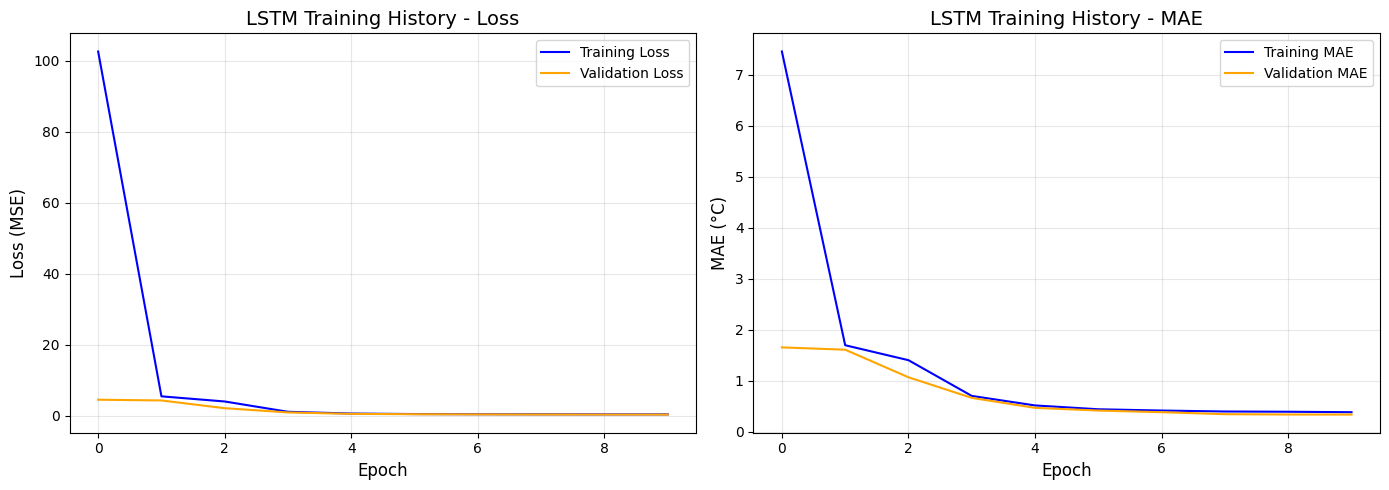

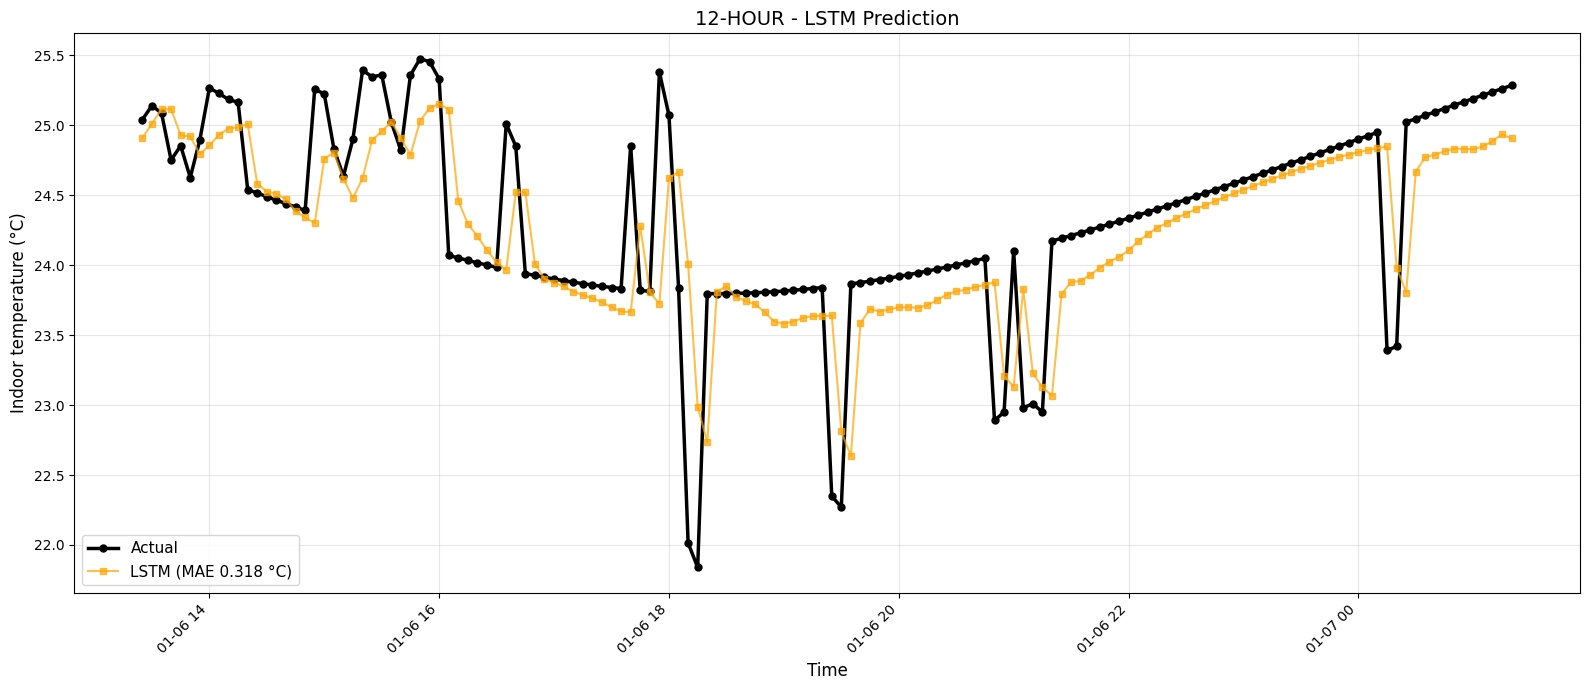

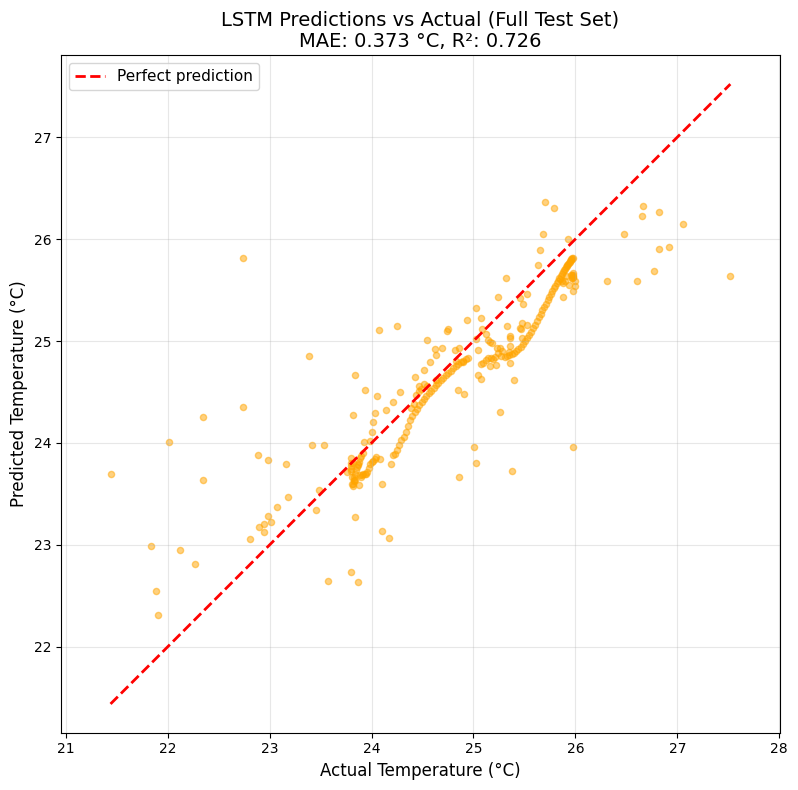


ANALYSIS COMPLETE FOR 12-HOUR WINDOW

LSTM Results Summary:
  Sequence length : 12 timesteps
  Full test MAE   : 0.3726 °C
  Window MAE      : 0.3178 °C
  Window RMSE     : 0.4792 °C
  Window R²       : 0.5364

Compare these results with FNN, ODE, PINN, and XGBoost models!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# BASIC SETTINGS
# -----------------------------
plt.rcParams["figure.figsize"] = (12, 4)

DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0          # 5-min data
TEST_DAYS = 1                    # last 1 day as test
SAMPLES_PER_DAY = 288            # 24*60 / 5
TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

# WINDOW SPECIFICATION - 1 HOUR
WINDOW_NAME = "12-hour"
WINDOW_SAMPLES = 144  # 1 hour = 12 samples (5-min intervals)

# LSTM CONFIGURATION
SEQUENCE_LENGTH = 12  # Use last 12 timesteps (1 hour) to predict next step

print("="*80)
print(f"LSTM Model - {WINDOW_NAME.upper()} Window Analysis")
print("="*80)
print(f"Sequence length: {SEQUENCE_LENGTH} timesteps (1 hour of history)")
print(f"Prediction: One-step ahead (next 5 minutes)")

try:
    full_data = pd.read_csv(DATA_FILE)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

    # Keep only rows where all key variables are present
    full_data = full_data.dropna(
        subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    ).reset_index(drop=True)

    if len(full_data) < TEST_SIZE:
        raise ValueError(f"Dataset too small! Need at least {TEST_SIZE} rows, got {len(full_data)}")

    print(f"\nTotal samples: {len(full_data)}")
    print(f"Date range  : {full_data['time'].min()} to {full_data['time'].max()}")

except FileNotFoundError:
    print(f"ERROR: Data file '{DATA_FILE}' not found in current directory.")
    raise
except Exception as e:
    print("ERROR while loading data:", e)
    raise

# Split into train and test (SAME AS OTHER MODELS)
train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples : {len(test_data)}")
print(f"Analyzing {WINDOW_NAME} window ({WINDOW_SAMPLES} samples)\n")

# =========================================================
# PREPARE SEQUENCES FOR LSTM
# =========================================================

def create_sequences(data, seq_length):
    """
    Create sequences for LSTM
    Input: last seq_length timesteps of [supply_air, outdoor_temp, satellite_value, indoor_temp]
    Output: indoor_temp at next timestep (one-step ahead prediction)
    """
    features = ["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    
    X_sequences = []
    y_targets = []
    
    for i in range(seq_length, len(data)):
        # Input: last seq_length rows
        X_sequences.append(data[features].iloc[i-seq_length:i].values)
        # Target: indoor_temp at current timestep
        y_targets.append(data["indoor_temp"].iloc[i])
    
    return np.array(X_sequences, dtype=np.float32), np.array(y_targets, dtype=np.float32)

print("Creating sequences for LSTM...")
X_train_seq, y_train = create_sequences(train_data, SEQUENCE_LENGTH)
X_test_seq, y_test = create_sequences(test_data, SEQUENCE_LENGTH)

print(f"Train sequences shape: {X_train_seq.shape}")  # (N, seq_len, 4)
print(f"Test sequences shape: {X_test_seq.shape}")
print(f"Train targets shape: {y_train.shape}")
print(f"Test targets shape: {y_test.shape}")

# =========================================================
# SCALE DATA
# =========================================================

# Scale features
scaler_X = RobustScaler()
X_train_flat = X_train_seq.reshape(-1, X_train_seq.shape[-1])
X_test_flat = X_test_seq.reshape(-1, X_test_seq.shape[-1])

X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_test_scaled_flat = scaler_X.transform(X_test_flat)

X_train_scaled = X_train_scaled_flat.reshape(X_train_seq.shape)
X_test_scaled = X_test_scaled_flat.reshape(X_test_seq.shape)

# Don't scale targets - keep in original units for fair comparison
# (Other models also predict in original units)

print(f"\nScaled train sequences shape: {X_train_scaled.shape}")
print(f"Scaled test sequences shape: {X_test_scaled.shape}")

# =========================================================
# BUILD AND TRAIN LSTM MODEL
# =========================================================

print("\nBuilding LSTM model...")

model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, 4)),  # (sequence_length, num_features)
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output: single value (indoor_temp)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(model.summary())

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining LSTM model...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# =========================================================
# MAKE PREDICTIONS
# =========================================================

print("\nMaking predictions...")
y_pred_train = model.predict(X_train_scaled, verbose=0).flatten()
y_pred_test = model.predict(X_test_scaled, verbose=0).flatten()

# =========================================================
# FULL TEST SET METRICS
# =========================================================

lstm_mae_full = mean_absolute_error(y_test, y_pred_test)
lstm_rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_test))
lstm_r2_full = r2_score(y_test, y_pred_test)
lstm_train_mae = mean_absolute_error(y_train, y_pred_train)

print("\nLSTM Performance on Full Test Set:")
print(f"  Train MAE: {lstm_train_mae:.4f} °C")
print(f"  Test MAE : {lstm_mae_full:.4f} °C")
print(f"  Test RMSE: {lstm_rmse_full:.4f} °C")
print(f"  Test R²  : {lstm_r2_full:.4f}")

# =========================================================
# WINDOW-SPECIFIC METRICS
# =========================================================

print("\n" + "="*80)
print(f"METRICS FOR {WINDOW_NAME.upper()} WINDOW ({WINDOW_SAMPLES} samples)")
print("="*80)

# Calculate metrics for the specific window
window_size = min(WINDOW_SAMPLES, len(y_test))

lstm_mae_w = mean_absolute_error(y_test[:window_size], y_pred_test[:window_size])
lstm_rmse_w = np.sqrt(mean_squared_error(y_test[:window_size], y_pred_test[:window_size]))
lstm_r2_w = r2_score(y_test[:window_size], y_pred_test[:window_size])

print(f"\n{'Model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'LSTM':<18} {lstm_mae_w:<12.4f} {lstm_rmse_w:<12.4f} {lstm_r2_w:<8.4f}")

# =========================================================
# TRAINING HISTORY VISUALIZATION
# =========================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('LSTM Training History - Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', color='blue')
ax2.plot(history.history['val_mae'], label='Validation MAE', color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE (°C)', fontsize=12)
ax2.set_title('LSTM Training History - MAE', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =========================================================
# PREDICTION VISUALIZATION
# =========================================================

# Prepare time axis for test data (accounting for sequence length)
time_test = test_data["time"].iloc[SEQUENCE_LENGTH:SEQUENCE_LENGTH+window_size].values
y_true_w = y_test[:window_size]
lstm_pred_w = y_pred_test[:window_size]

plt.figure(figsize=(16, 7))
plt.plot(time_test, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_test, lstm_pred_w, "s-", label=f"LSTM (MAE {lstm_mae_w:.3f} °C)", 
         color="orange", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()} - LSTM Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# =========================================================
# SCATTER PLOT: PREDICTED VS ACTUAL
# =========================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5, s=20, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.title(f'LSTM Predictions vs Actual (Full Test Set)\nMAE: {lstm_mae_full:.3f} °C, R²: {lstm_r2_full:.3f}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# =========================================================
# COMPARISON SUMMARY
# =========================================================

print("\n" + "="*80)
print(f"ANALYSIS COMPLETE FOR {WINDOW_NAME.upper()} WINDOW")
print("="*80)
print(f"\nLSTM Results Summary:")
print(f"  Sequence length : {SEQUENCE_LENGTH} timesteps")
print(f"  Full test MAE   : {lstm_mae_full:.4f} °C")
print(f"  Window MAE      : {lstm_mae_w:.4f} °C")
print(f"  Window RMSE     : {lstm_rmse_w:.4f} °C")
print(f"  Window R²       : {lstm_r2_w:.4f}")
print("\nCompare these results with FNN, ODE, PINN, and XGBoost models!")
print("="*80)